In [170]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy

from cryptic_rnn import *

In [171]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
rp = generate_other_reverse_primitives('+', all_syms, cue_dict)
print(primitives)
print(rp)
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)

{'A': 9, 'B': 12, 'C': 13, 'D': 17}
[['A', '=', 9], ['B', '=', 12], ['C', '=', 13], ['D', '=', 17]]
[['A', ('+', 'C'), '=', 22], ['B', ('+', 'D'), '=', 29]]


In [195]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 


## calculate distance matrices for all models and steps 

def calculate_RDMs(res, fully_trained = True):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    if fully_trained:
        all_acc_mods = acc_df[(acc_df['acc_train_rp'] == 1) & (acc_df['acc_train_p'] == 1)].index
    else:
        all_acc_mods = acc_df.index
    
    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose subset of rnns 
    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods_rp']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms, cue_dict)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}

# for ranked control
rank_dict = {'A': -1.5, 'B': -0.5, 'C': 0.5, 'D': 1.5}

# for selecting untrained trials
rp = generate_other(ops, all_syms, cue_dict) + generate_other_reverse_primitives('+', all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

def regress_RDM_abs(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = []
        y = []
        for p in valset_idx:
            for q in valset_idx:
                x.append(rdm[time_step][i][p,q])
                y.append(truth_RDM[p,q])
        x = np.array(x).reshape(-1,1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs

def truth_RDM_init(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        init_tests = [[t[0]]+['='] for t in curr_tests ]
        truth_outs = [calculate_output(t, cuedict) for t in init_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs

def truth_RDM(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs



# 2 step

In [ ]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'res_all', 'rb') as f:
    res1 = pickle.load(f)

# Read data

In [188]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'res_all', 'rb') as f:
    res1 = pickle.load(f)

In [190]:
res1.keys()

dict_keys(['res', 'mods', 'mods_p', 'mods_rp', 'tests', 'cue_dicts', 'acc_df'])

## Other

In [196]:
res = calculate_RDMs(res1)
rdms = res['rdms']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
truth_list = [np.array(truth_RDM(t, rdms, cue_dicts)).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  403


In [168]:
# find indices of untrained trials
rp = generate_other(ops, all_syms, cue_dict) + generate_primitives(all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

In [199]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_np = pca.fit(matlist[2])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca_rp = pca.fit(matlist_p[2])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.74165514 0.21528101 0.01285364]
with prims:    [0.75850735 0.18953534 0.01950155]


step:  1 ; variance explained:    [0.34813273 0.33660514 0.31526213]
step:  2 ; variance explained:    [0.37399862 0.35442244 0.27157894]
step:  3 ; variance explained:    [0.38254218 0.31777491 0.23154057]
step:  4 ; variance explained:    [0.4009374  0.29735637 0.22300341]


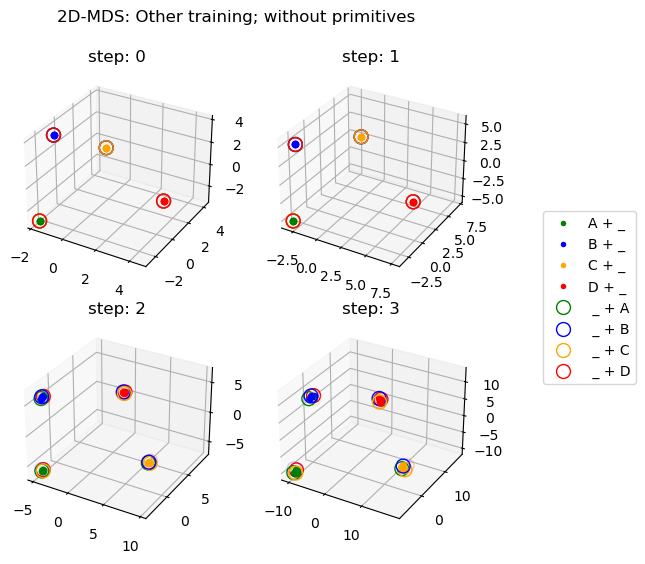

In [165]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))
#matlist = [rdms[t][m] for t in range(4)]
for j, mat in enumerate(matlist_p):
    pca = PCA(n_components=3)
    pca_fit = pca.fit_transform(mat)
    print('step: ', j+1,'; variance explained:   ', pca.explained_variance_ratio_)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(pca_fit[i,0], pca_fit[i,1], pca_fit[i,2],color = colors1[i], alpha = alph)
        ax.scatter(pca_fit[i,0], pca_fit[i,1], pca_fit[i,2],s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

array([-10.75809729, -10.82449485, -10.17458286, -11.06762805,
        -5.10355126,  -5.22125388,  -4.84544735,  -5.28276028,
        24.50607718,  24.08444698,  24.63091248,  24.24310892,
        -8.6240759 ,  -8.7517972 ,  -8.03311264,  -8.77774399])

In [173]:
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)


In [110]:
from matplotlib.lines import Line2D
colors2 = ['green', 'blue', 'orange', 'red']*4
colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]


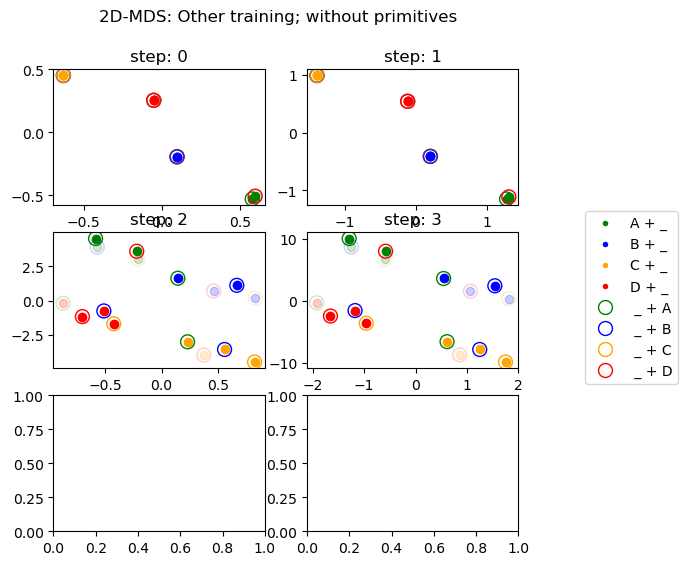

In [175]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(3,2)

for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

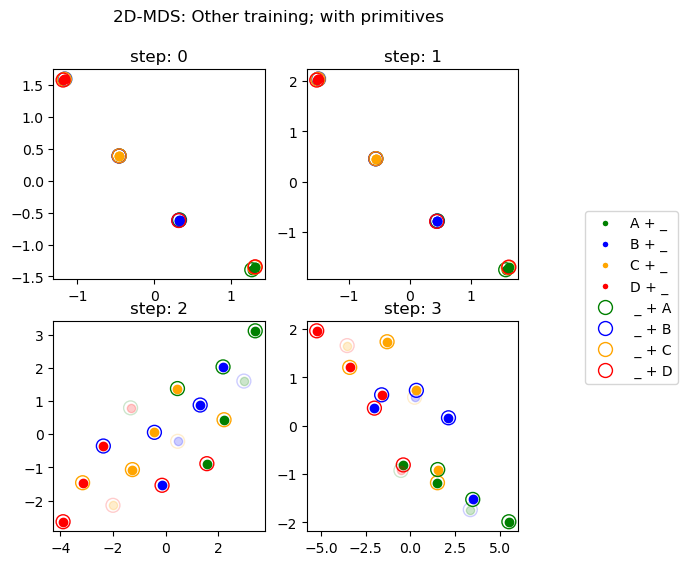

In [148]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; with primitives')
fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 

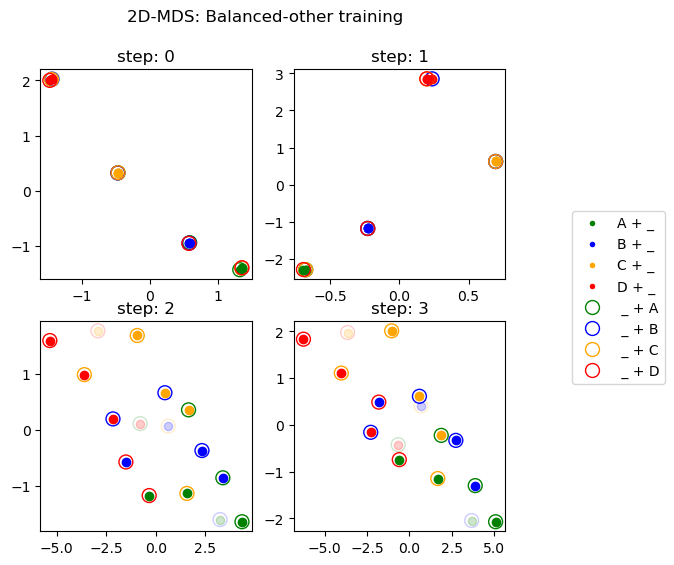

In [112]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_rp):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced-other training')
fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

# Lazy Regime

In [176]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'res_all_lazy', 'rb') as f:
    res1 = pickle.load(f)

In [177]:
def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    #all_acc_mods = acc_df.index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)& (acc_df['acc_train_rp'] == 1)].index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    all_acc_mods = acc_df[(acc_df['acc_train_rp'] == 1) & (acc_df['acc_train_p'] == 1)].index

    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    # mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_rp = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    mods_rp = res['mods_rp']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms, cue_dict)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_rp, trials = get_reps(mods_rp[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_rp])
            rep_mat = euclidean_distances(hid_vals)
            rdms_rp[h].append(rep_mat)
        
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_rp': rdms_rp,'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}


In [178]:
res = calculate_RDMs(res1)
rdms = res['rdms']
rdms_rp = res['rdms_rp']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_rp = [np.array(rdms_rp[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
truth_list = [np.array(truth_RDM(t, rdms, cue_dicts)).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  723


In [179]:
pca = PCA(n_components=3)
pca.fit(matlist[3])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(matlist_rp[3])
print('with reverseprims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(matlist_p[3])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.34787318 0.31520996 0.30311124]
with reverseprims:    [0.37219617 0.29134016 0.27695541]
with prims:    [0.4045639  0.29367344 0.22400624]


step:  1 ; variance explained:    [0.34593243 0.33927009 0.31479748]
step:  2 ; variance explained:    [0.37175858 0.35725848 0.27098295]
step:  3 ; variance explained:    [0.38545845 0.31730934 0.22976399]
step:  4 ; variance explained:    [0.4045639  0.29367344 0.22400624]


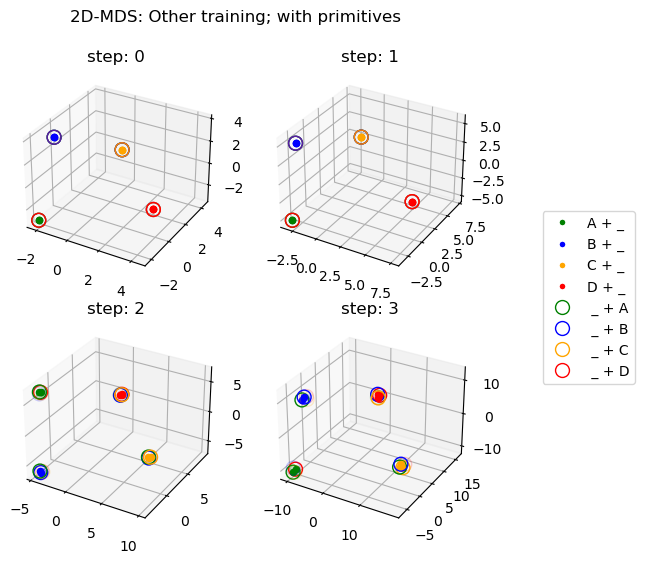

In [181]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))
#matlist = [rdms[t][m] for t in range(4)]
for j, mat in enumerate(matlist_p):
    pca = PCA(n_components=3)
    pca_fit = pca.fit_transform(mat)
    print('step: ', j+1,'; variance explained:   ', pca.explained_variance_ratio_)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(pca_fit[i,0], pca_fit[i,1], pca_fit[i,2],color = colors1[i], alpha = alph)
        ax.scatter(pca_fit[i,0], pca_fit[i,1], pca_fit[i,2],s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; with primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

step:  1 ; variance explained:    [0.3399906  0.33247578 0.32753362]
step:  2 ; variance explained:    [0.34421584 0.33814182 0.31764233]
step:  3 ; variance explained:    [0.34233394 0.33033307 0.29821339]
step:  4 ; variance explained:    [0.34787318 0.31520996 0.30311124]


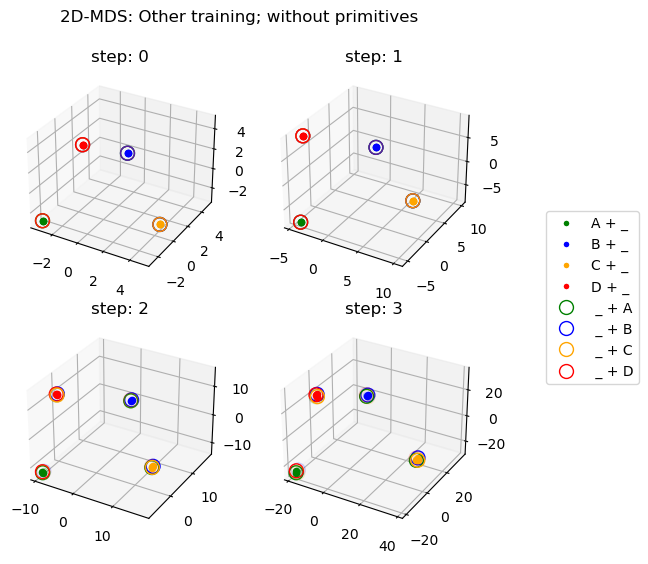

In [182]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))
#matlist = [rdms[t][m] for t in range(4)]
for j, mat in enumerate(matlist):
    pca = PCA(n_components=3)
    pca_fit = pca.fit_transform(mat)
    print('step: ', j+1,'; variance explained:   ', pca.explained_variance_ratio_)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(pca_fit[i,0], pca_fit[i,1], pca_fit[i,2],color = colors1[i], alpha = alph)
        ax.scatter(pca_fit[i,0], pca_fit[i,1], pca_fit[i,2],s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

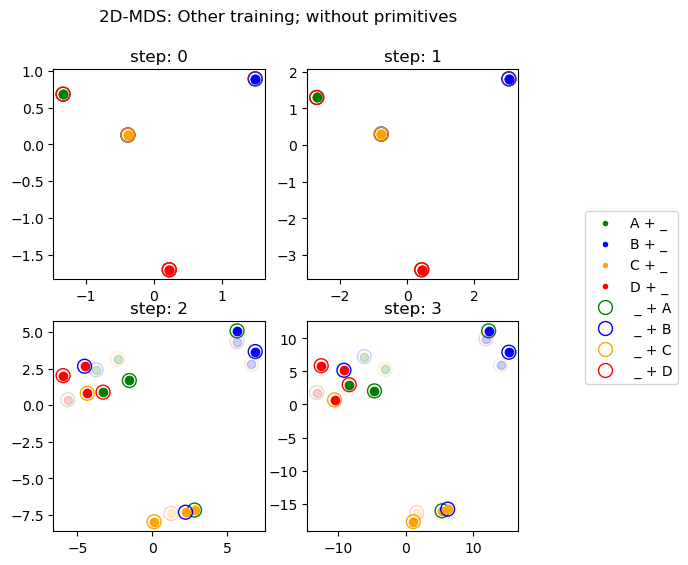

In [184]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

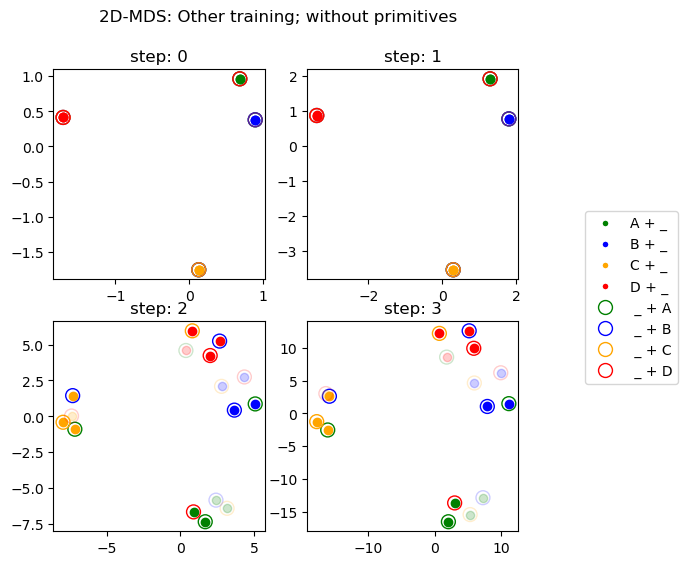

In [185]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=3)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,1], X_transform[i,2], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,1], X_transform[i,2], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

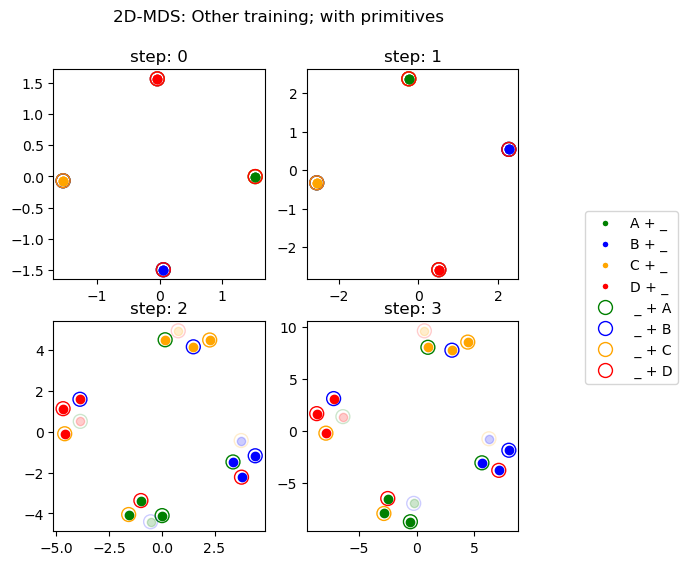

In [128]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; with primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

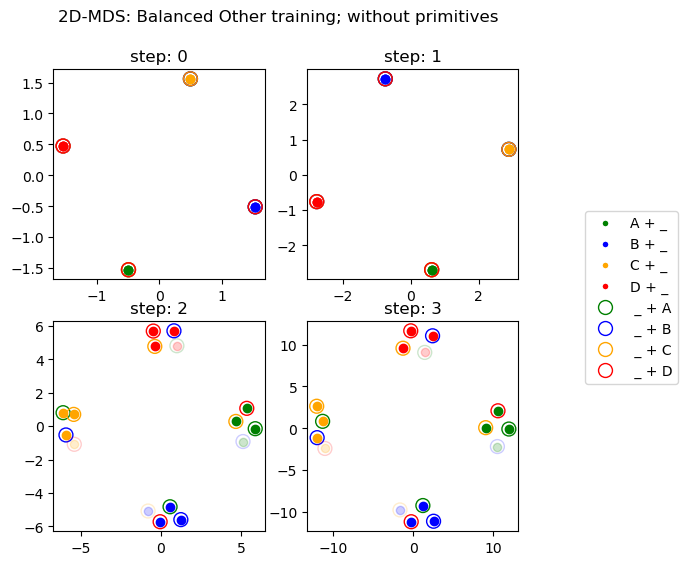

In [129]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_rp):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced Other training; without primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 0.98, '2D-MDS: Other training; without primitives')

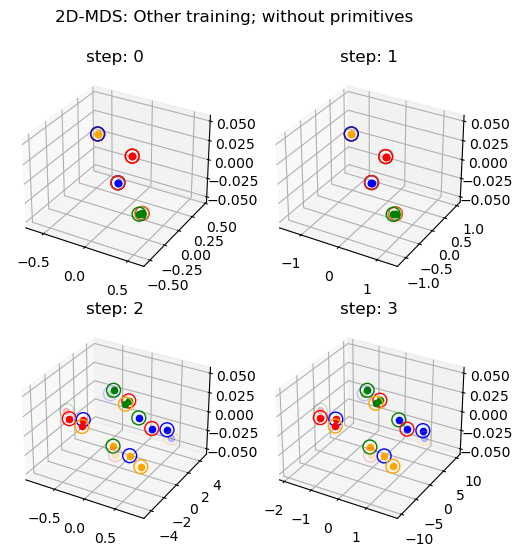

In [27]:
plt.rcParams['figure.figsize'] = 6, 6
#fig, axs = plt.subplots(2,2,subplot_kw=dict(projection='3d'))

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')
 

Text(0.5, 0.98, '2D-MDS: Other training; with primitives')

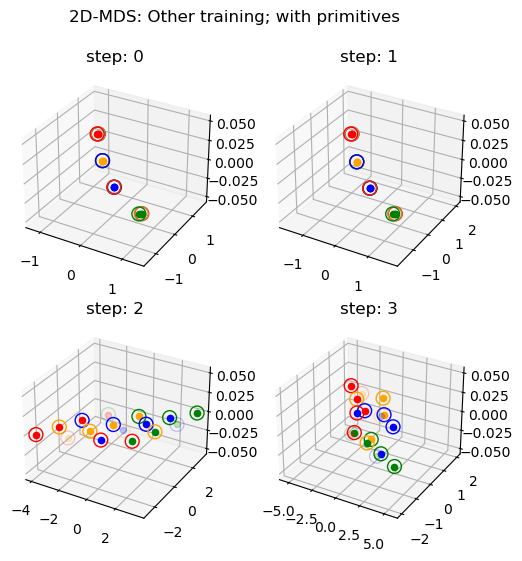

In [28]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,subplot_kw=dict(projection='3d'))

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; with primitives')


Text(0.5, 0.98, '2D-MDS: Balanced Other training; with primitives')

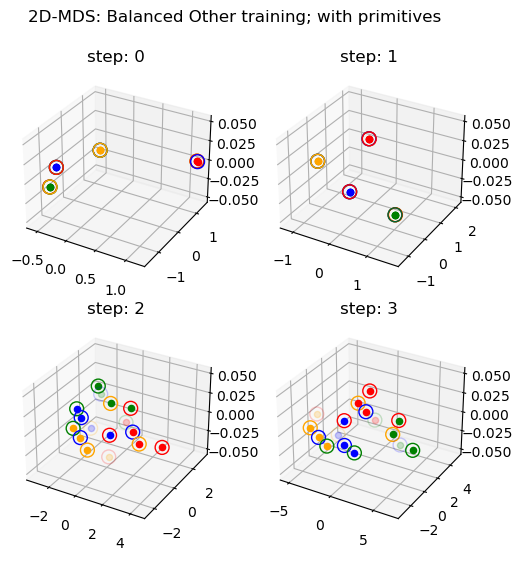

In [29]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,subplot_kw=dict(projection='3d'))

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_rp):
    mds = MDS(dissimilarity='precomputed',random_state=3, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced Other training; with primitives')


Text(0.5, 0.98, '2D-MDS: Balanced Other training; with primitives')

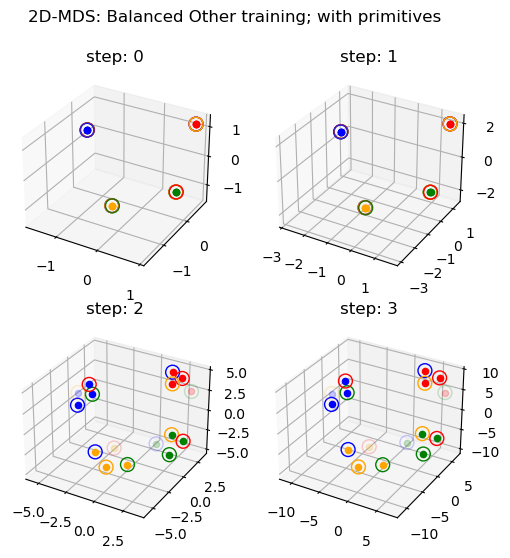

In [18]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2, subplot_kw=dict(projection='3d'))

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_rp):
    mds = MDS(dissimilarity='precomputed',random_state=3, n_components=3)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], X_transform[i,2],  color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], X_transform[i,2], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced Other training; with primitives')


## Full

In [181]:
res = calculate_RDMs(res2)
rdms = res['rdms']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
truth_list = truth_RDM(3, rdms, cue_dicts).mean(axis=0)

no. 100% trained RNNs:  247


Text(0.5, 0.98, '2D-MDS: Full training; without primitives')

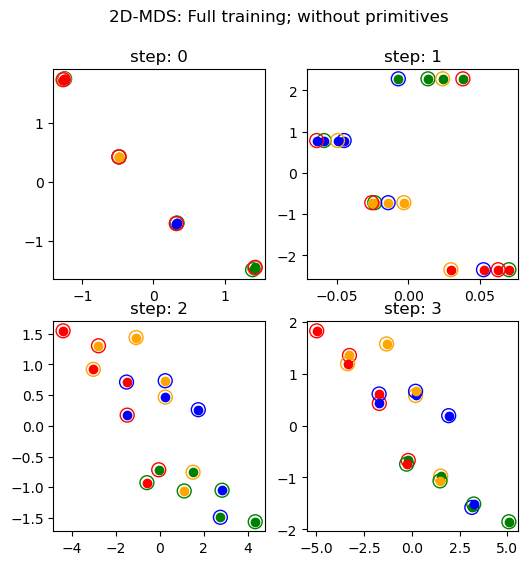

In [164]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])

plt.suptitle('2D-MDS: Full training; without primitives')
 

Text(0.5, 0.98, '2D-MDS: Full training; with primitives')

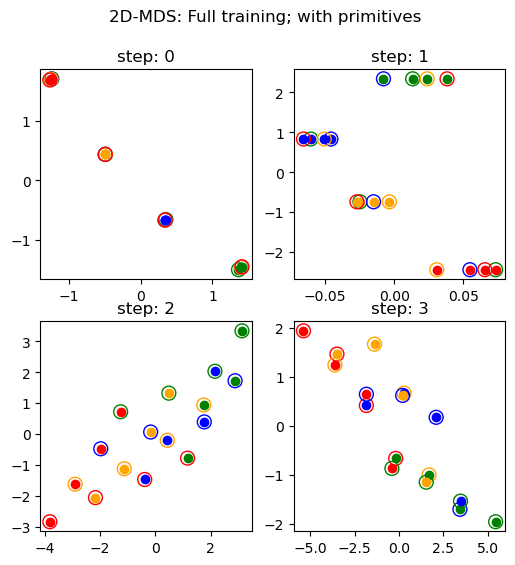

In [165]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])

plt.suptitle('2D-MDS: Full training; with primitives')
 

## Balanced 

In [257]:
res = calculate_RDMs(res3)
rdms = res['rdms']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
truth_list = [np.array(truth_RDM(t, rdms, cue_dicts)).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  280


In [258]:
rp = generate_other(ops, all_syms) + generate_other_reverse_primitives('+', all_syms)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]


In [259]:
pca = PCA(n_components=3)
pca.fit(matlist[3])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(matlist_p[3])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.7228241  0.24316275 0.01235727]
with prims:    [0.71931991 0.24882807 0.01228221]


Text(0.5, 0.98, '2D-MDS: Balanced training; without primitives')

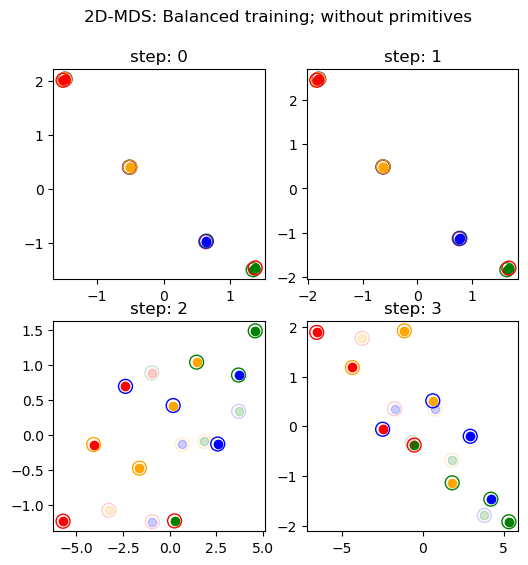

In [260]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced training; without primitives')
 

Text(0.5, 0.98, '2D-MDS: Balanced training; with primitives')

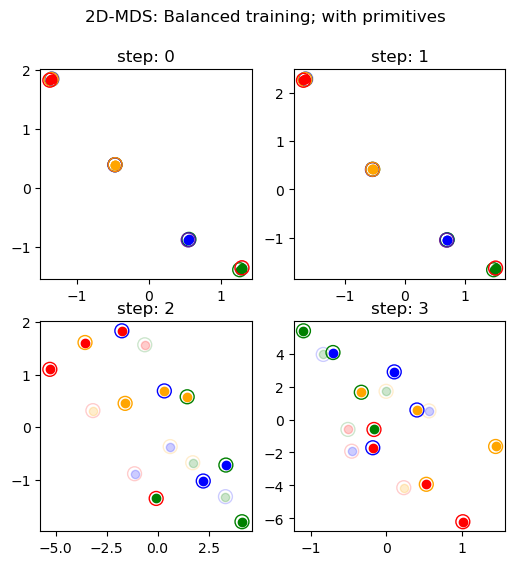

In [261]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Balanced training; with primitives')
 

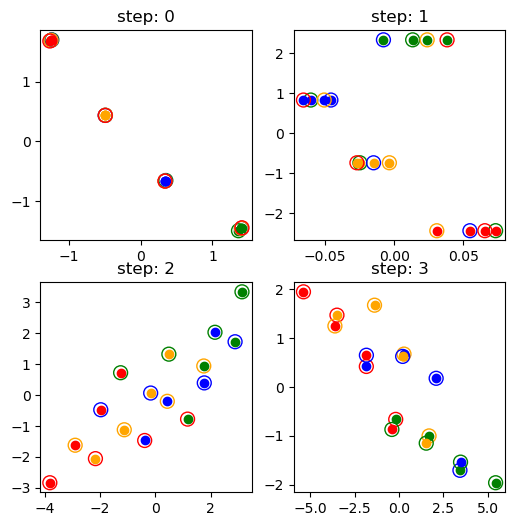

In [131]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2,)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])

    
 

In [207]:
truth_final = np.array(truth_RDM(rdms_p, cue_dicts)).mean(axis=0)
truth_init = np.array(truth_RDM_init(rdms_p, cue_dicts)).mean(axis=0)

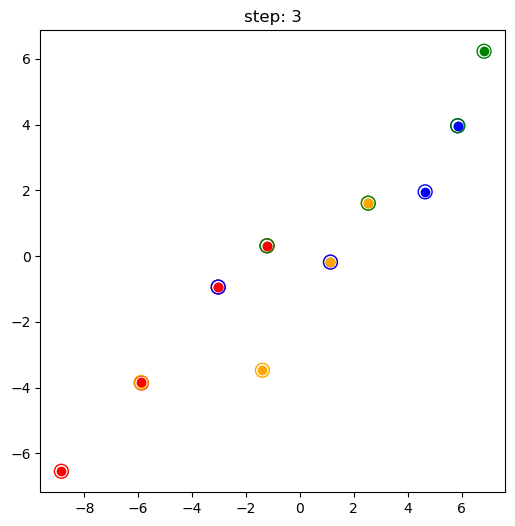

In [209]:
mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
X_transform = mds.fit_transform(truth_final)
fig, ax = plt.subplots(1,1)
ax.title.set_text('step: '+str(j))
for i in range(len(testseqs)):
    ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
    ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])


In [194]:
pca = PCA(n_components=3)
pca.fit(truth_list[3])
print('no prims:   ', pca.explained_variance_ratio_)
pca = PCA(n_components=3)
pca.fit(truth_list[2])
print('with prims:   ', pca.explained_variance_ratio_)

no prims:    [0.71623798 0.2490412  0.01367331]
with prims:    [0.71623798 0.2490412  0.01367331]
